Problem statement


 Itr:	 1
loss: 8.211


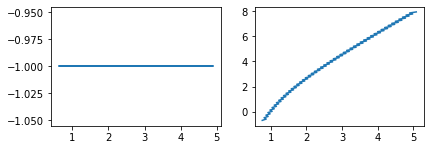


 Itr:	 2
loss: 4.100


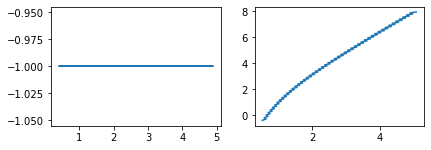


 Itr:	 3
loss: 2.499


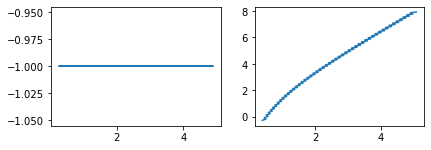


 Itr:	 4
loss: 1.781


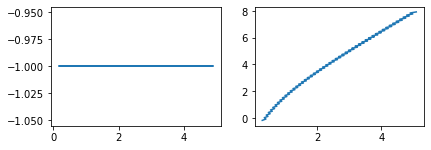


 Itr:	 5
loss: 1.435


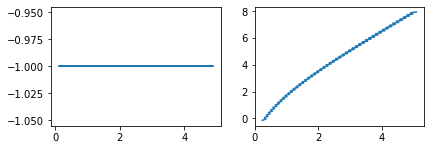


 Itr:	 6
loss: 1.255


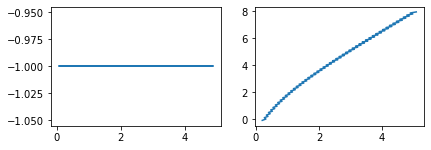


 Itr:	 7
loss: 1.155


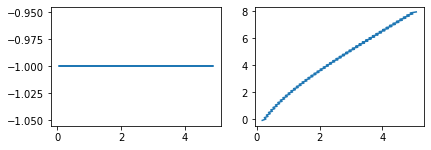


 Itr:	 8
loss: 1.095


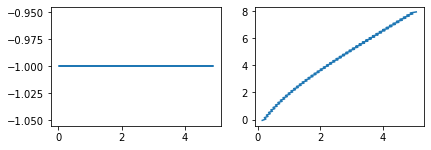


 Itr:	 9
loss: 1.057


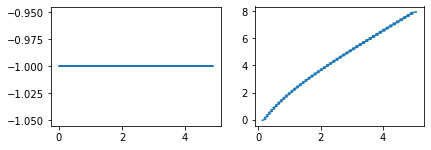


 Itr:	 10
loss: 1.034


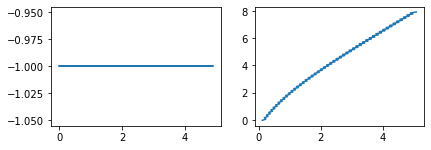


 Itr:	 11
loss: 1.021


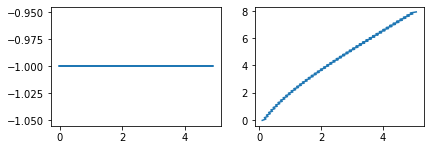


 Itr:	 12
loss: 1.013


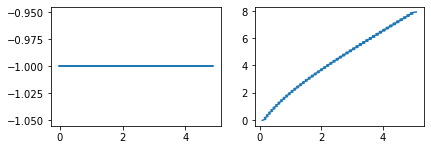


 Itr:	 13
loss: 1.010


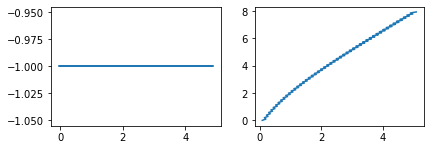


 Itr:	 14
loss: 1.007


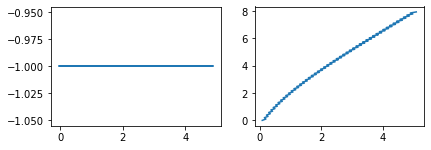


 Itr:	 15
loss: 1.006


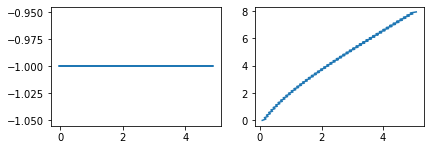


 Itr:	 16
loss: 1.005


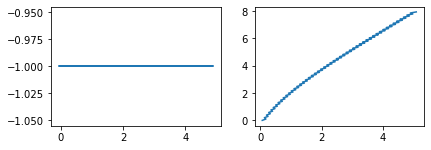


 Itr:	 17
loss: 1.004


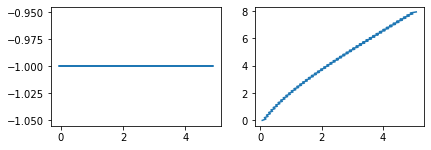


 Itr:	 18
loss: 1.004


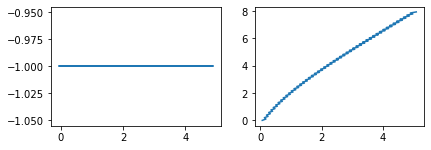


 Itr:	 19
loss: 1.004


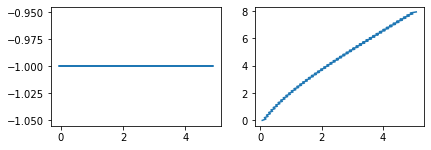


 Itr:	 20
loss: 1.004


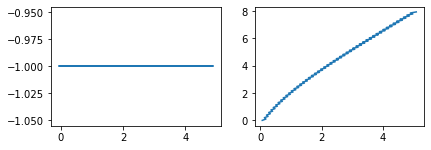


 Itr:	 21
loss: 1.004


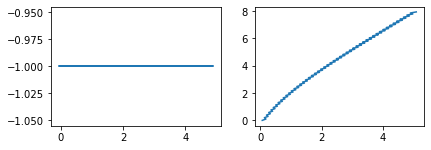


 Itr:	 22
loss: 1.004


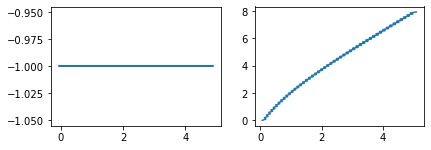


 Itr:	 23
loss: 1.004


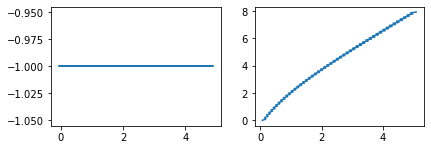


 Itr:	 24
loss: 1.004


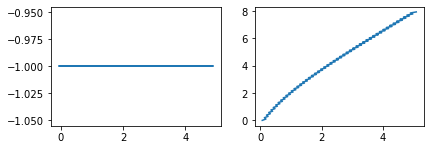


 Itr:	 25
loss: 1.004


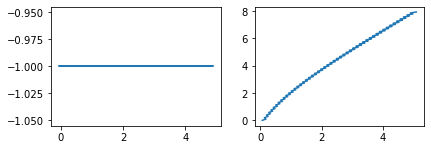


 Itr:	 26
loss: 1.004


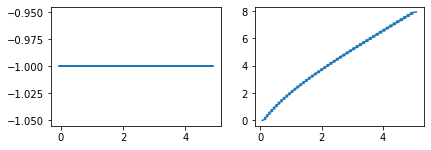


 Itr:	 27
loss: 1.004


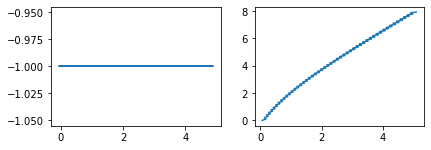


 Itr:	 28
loss: 1.004


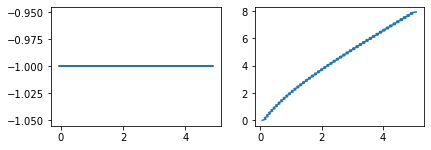


 Itr:	 29
loss: 1.004


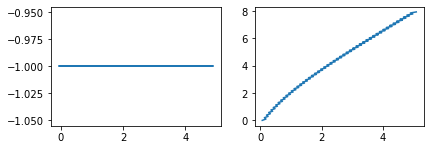


 Itr:	 30
loss: 1.004


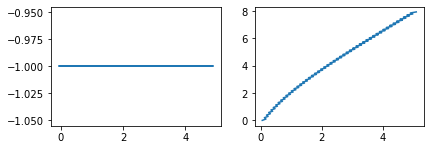


 Itr:	 31
loss: 1.003


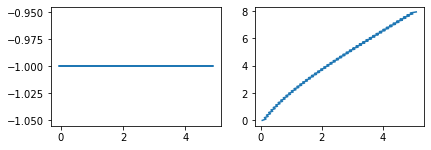


 Itr:	 32
loss: 1.002


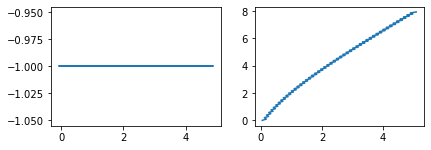


 Itr:	 33
loss: 1.001


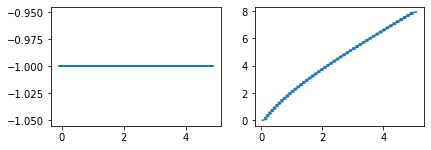


 Itr:	 34
loss: 1.001


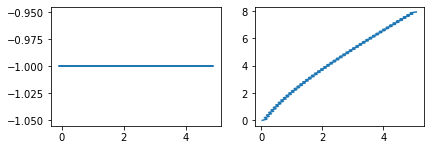


 Itr:	 35
loss: 1.000


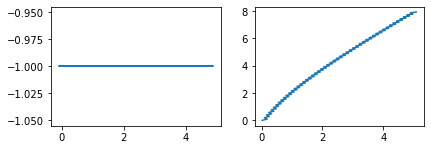


 Itr:	 36
loss: 1.000


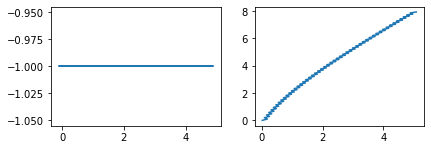


 Itr:	 37
loss: 1.000


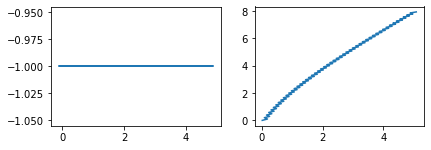


 Itr:	 38
loss: 1.000


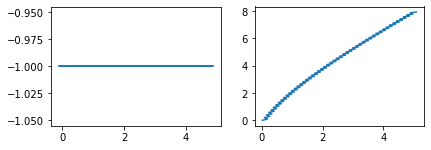


 Itr:	 39
loss: 1.000


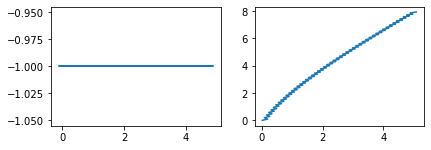


 Itr:	 40
loss: 1.000


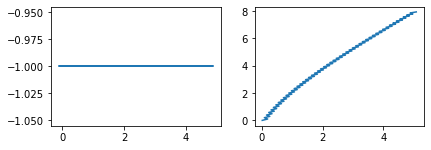

In [32]:
# overhead

import logging
# import math
# import random
import numpy as np
# import time
import torch as t
import torch.nn as nn
from torch import optim
# from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# environment parameters

Time_step = 0.01  # time interval
Gra_acc = 9.81  # gravity constant
Thruster_acc = 20.0  # thrust constant converges only for 15

# # the following parameters are not being used in the sample code
# PLATFORM_WIDTH = 0.25  # landing platform width
# PLATFORM_HEIGHT = 0.06  # landing platform height
# ROTATION_ACCEL = 20  # rotation constant

"""Constraint 1: Trying to include drag in y direction (upward) but it's going to e less then the thrust"""
"""Constraint 2: Including the crosswind as a randomness variable"""
"""Constraint 3: This constraint is sort of side counter thrust to crosswind which acts
with 90% the power of crosswind because if its same as cross wind it basically cancels each other"""


class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):
        """
        action: there are three of them
        action[0]: take off or landing thrust in y direction range (0, 1)
        action[1]: cross wind velocity in x direction range (-1, 1)
                -1 - cross wind to the left // 0 - no cross wind // 1 - cross wind to the right
        action[2]: counter side thrust to cross wind but at 90% power range (-1, 1)
                -1 - side thrust to the right // 0 - no side thrust // 1 - side thrust to left
        state[0] = x // state[1] = v_x // state[2] = x // state[3] = 0.9*v_x // state[4] = y // state[5] = v_y
        """
        vertical_thrust_y = action[0]
        crosswind = action[1]
        side_c_thrust = action[2]
        # drag = action[3]
        # Apply gravity
        del_state_gravity = -t.tensor([0., 0., 0., 0., 0., Gra_acc * Time_step])
        del_state_y = Thruster_acc * Time_step * t.tensor([0., 0., 0., 0., 0., -1.]) * action[0]
        # del_state_x = Thruster_acc * Time_step * t.tensor([0., 0., 0., 1.]) * action[1]
        # Thrust # Note: Same reason as above. Need a 2-by-1 tensor.
        temp = del_state_y
        d_decel = 0.00658 * temp * temp
        net_acc = Thruster_acc - d_decel
        del_state_vertical = net_acc * Time_step * t.tensor([0., 0., 0., 0., 0., -1.]) * vertical_thrust_y  # 1
        del_state_crosswind = net_acc * Time_step * t.tensor([0., 1., 0., 0., 0., 0.]) * crosswind  # 2
        # del_state_crosswind_l = Thruster_acc * Time_step * t.tensor([0., -1., 0., 0., 0., 0.]) * action[
        #     1] * crosswind  # 3
        del_state_side_thrust = 0.9 * (net_acc * Time_step * t.tensor([0., 0., 0., -1., 0., 0.]) * side_c_thrust)  # 4
        # del_state_side_thrust_r = Thruster_acc * Time_step * t.tensor([0., 0., 0., 1., 0., 0.]) * action[
        #     2] * side_c_thrust  # 5
        # Update velocity
        # state = state + del_state_vertical + del_state_crosswind + del_state_crosswind_l + del_state_side_thrust_r + del_state_side_thrust + del_state_gravity  # drag part goes in here

        state = state + del_state_vertical + del_state_crosswind + del_state_side_thrust + del_state_gravity  # drag part goes in here
        # Update state
        # Note: Same as above. Use operators on matrices/tensors as much as possible.
        # Do not use element-wise operators as they are considered inplace.
        # step_mat = t.tensor([[1., 0., 0., 0., 0., 0.],
        #                      [Time_step, 1., 0., 0., 0., 0.],
        #                      [0., 0., 1., 0., 0., 0.],
        #                      [0., 0., Time_step, 1., 0., 0.],
        #                      [0., 0., 0., 0., 1., 0.],
        #                      [0., 0., 0., 0., Time_step, 1.]])
        step_mat = t.tensor([[0., 0., 0., 0., 1., 0.],
                             [0., 0., 0., 0., Time_step, 1.],
                             [0., 0., 1., 0., 0., 0.],
                             [0., 0., Time_step, 1., 0., 0.],
                             [1., 0., 0., 0., 0., 0.],
                             [Time_step, 1., 0., 0., 0., 0.]])
        state = t.matmul(step_mat, state)

        return state

        # print(type(state))


# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or
# deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action


# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time


class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        #  state 0   1   2   3   4   5
        state = [0, 5., -1., 8., 0., 5.]  # need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    @staticmethod
    def error(state):
        return state[0] ** 2 + 10 * state[1] ** 2 + state[2] ** 2 + 4 * state[3] ** 2 + state[4] ** 2 + state[5] ** 2


# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial
#    states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('\n Itr:\t',epoch + 1)
            print('loss: %.3f' % (loss))
            self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
#         print(data)
        x = data[:, 1]
        y = data[:, 2]
        a = data[:, 5]
        b = data[:, 3]
        
        plt.figure()
        plt.subplot(221)
        plt.plot(x, y)
        
        plt.subplot(222)
        plt.plot(a, b)
        plt.tight_layout()
        plt.show()
        
#         plt.plot(x, y)
#         plt.show()
#         if o == 40:
#             data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
#             x = data[:, 0]
#             y = data[:, 1]
#             plt.plot(x, y)
#             plt.show()


# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 6  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 3  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(40)  # solve the optimization problem
# print(s)
# print(type(s))
# print(d)
# print(c)
